In [66]:
import sys
sys.path.append("/Users/ktakeda/workspace/kaggle/rsna-breast-cancer-detection")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
from omegaconf import OmegaConf
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm import tqdm
from rsna.utility import load_data
from rsna.preprocess import df_preprocess, Transform
from rsna.dataset import *

# データ読み込み

In [48]:
df_train = load_data("train", custom_path="/Users/ktakeda/workspace/kaggle/rsna-breast-cancer-detection/data/dicom2png_512", external=False)
df_train = df_preprocess(df_train, is_train=True, sampling="normal")
df_train.head()

/Users/ktakeda/workspace/kaggle/rsna-breast-cancer-detection/rsna/preprocess.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["laterality_LE"] = encoded_laterality
/Users/ktakeda/workspace/kaggle/rsna-breast-cancer-detection/rsna/preprocess.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["view_LE"] = encoded_view
/Users/ktakeda/workspace/kaggle/rsna-breast-cancer-detection/rsna/preprocess.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

,patient_id,image_id,laterality,view,age,implant,path,cancer,laterality_LE,view_LE
0,10006,462822612,L,CC,61.0,0,/Users/ktakeda/workspace/kaggle/rsna-breast-ca...,0,0,1
1,10006,1459541791,L,MLO,61.0,0,/Users/ktakeda/workspace/kaggle/rsna-breast-ca...,0,0,5
2,10006,1864590858,R,MLO,61.0,0,/Users/ktakeda/workspace/kaggle/rsna-breast-ca...,0,1,5
3,10006,1874946579,R,CC,61.0,0,/Users/ktakeda/workspace/kaggle/rsna-breast-ca...,0,1,1
4,10011,220375232,L,CC,55.0,0,/Users/ktakeda/workspace/kaggle/rsna-breast-ca...,0,0,1


# Augmentation

In [49]:
with open("../conf/param_20230219.yaml") as f:
    cfg = yaml.safe_load(f)

cfg = OmegaConf.create(cfg)

transform = Transform(cfg)
train_dataset = RSNADatasetPNG(df_train, transform.get(is_train=True), cfg.csv_columns, has_target=True, image_prep_ver=cfg.preprocess.img_prep_version)

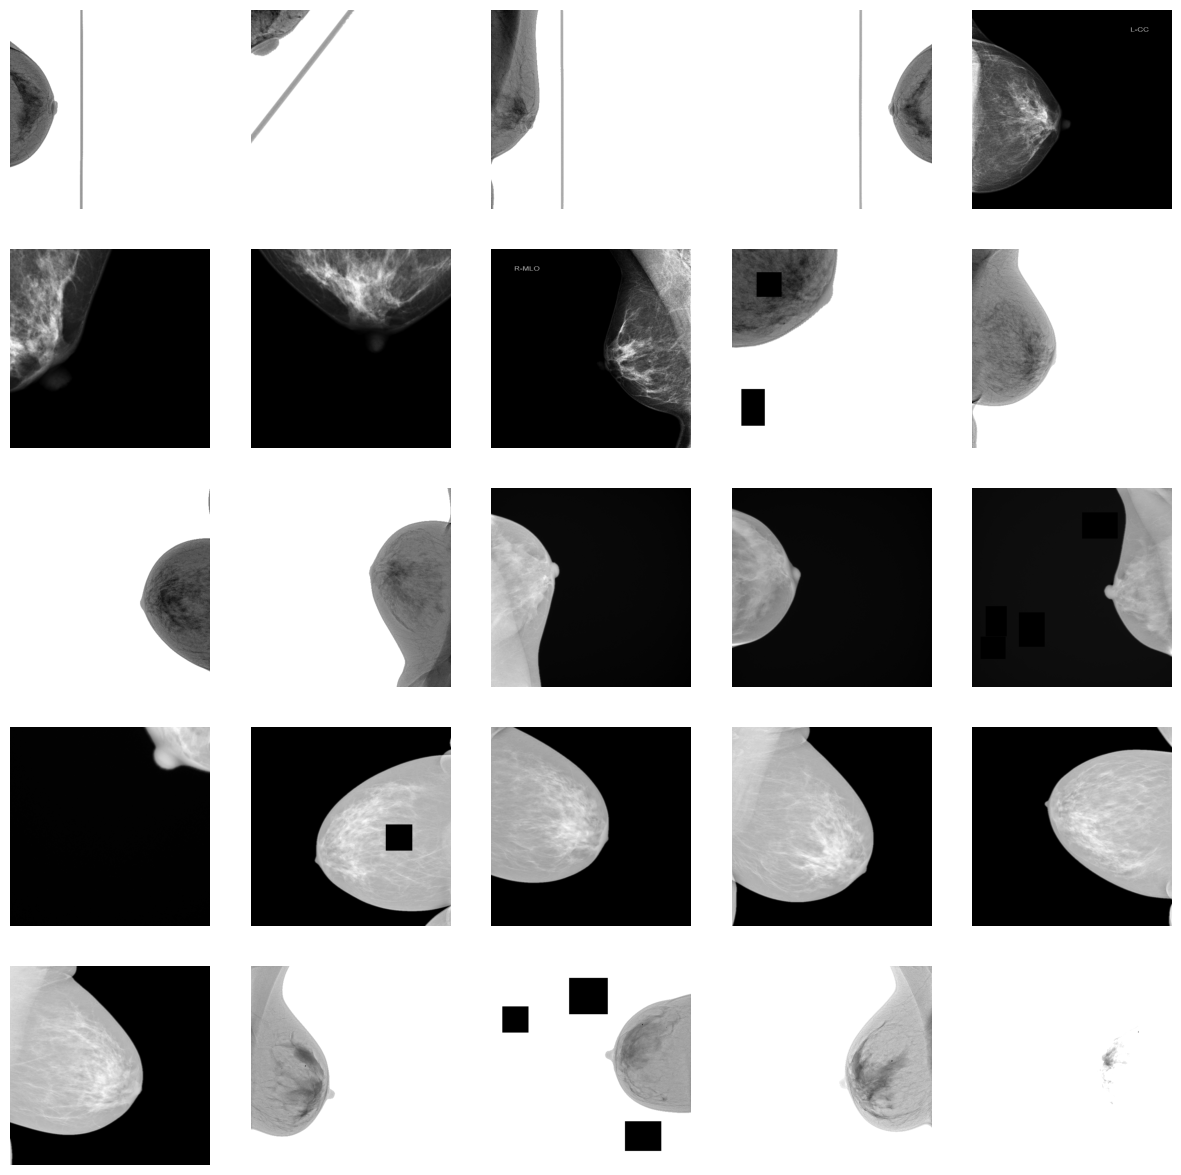

In [53]:
fig, axs = plt.subplots(5,5, figsize=(15,15))
for idx, ax in enumerate(axs.flatten()):
    ax.imshow(train_dataset[idx]["image"][0,:,:], cmap="gray")
    ax.axis("off")

In [55]:
train_dataset = RSNADatasetPNG(df_train, transform.get(is_train=True), cfg.csv_columns, has_target=True, image_prep_ver=cfg.preprocess.img_prep_version)
train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size_1, shuffle=True, num_workers=cfg.num_workers, pin_memory=True)

In [67]:
ratio_list = []

for data in tqdm(train_loader, total=len(train_loader)):
    y_target = data["target"].numpy()
    cancer_0 = len(np.where(y_target==0)[0])
    cancer_1 = len(np.where(y_target==1)[0])

    ratio_list.append(cancer_1/len(y_target))

100%|██████████| 3420/3420 [03:39<00:00, 15.59it/s]


(array([2423.,    0.,    0.,  852.,    0.,    0.,  129.,    0.,    0.,
          16.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ]),
 <BarContainer object of 10 artists>)

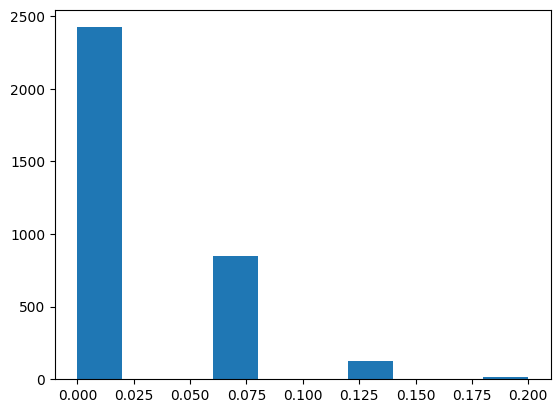

In [69]:
plt.hist(ratio_list, range=(0, 0.2))

In [70]:
rdata = np.array(ratio_list)

In [76]:
len(rdata), len(np.where(rdata==0)[0])/len(rdata), len(np.where(rdata>0)[0])

(3420, 0.7084795321637427, 997)

# Downsampling 時でのバッチ内の特性

In [ ]:
df_train_down = load_data("train", custom_path="/Users/ktakeda/workspace/kaggle/rsna-breast-cancer-detection/data/dicom2png_512", external=False)
df_train_down = df_preprocess(df_train_down, is_train=True, sampling="down")

train_dataset = RSNADatasetPNG(df_train, transform.get(is_train=True), cfg.csv_columns, has_target=True, image_prep_ver=cfg.preprocess.img_prep_version)
train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size_1, shuffle=True, num_workers=cfg.num_workers, pin_memory=True)